# CIFAR Experiments

Notebook for evaluating our models on the classic CIFAR dataset.

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T

import time
import numpy as np
import matplotlib.pyplot as plt

from data_utils import get_CIFAR10_data

In [2]:
%load_ext autoreload
%autoreload 2

from modules import OctConv2dStackable, get_stacked_4
from modules import get_SixLayerConvNet, get_SixLayerOctConvNet
from octconv_tests import test_octconv_shapes, test_octconv_as_conv


In [3]:
#231N Assignment 2

USE_GPU = True
print_every = 100

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Load CIFAR Data

The following code should download the CIFAR data automatically. If not, you can do so by navigating to the `datasets` directory and running the `$ ./get_datasets.sh` command from the command line.

In [4]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
cifar10_train[0][0].shape

torch.Size([3, 32, 32])

## Train Vanilla Model on CIFAR

We're training a pretty vanilla six-layer convolutional network on CIFAR. Implementation details can be found in modulesStackable.py.

In [6]:
def check_accuracy(loader, model):
    """
    Checks accuracy of model on given data loader.
    Code adapted from 231N Assignment 2.
    """
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    
    # returns accuracy for plotting later
    return acc

In [7]:
def train_cifar(model, optimizer, scheduler=None, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    Code adapted from 231N assignment 2.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: a tuple comprising
    - a list of training losses per "print_every" iterations
    - a list of model accuracies during training per "print_every" iterations
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    losses = []
    accs = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if scheduler:
                scheduler.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc = check_accuracy(loader_val, model)
                print()
                losses.append(loss.item())
                accs.append(acc)
    return losses, accs

In [17]:
vanilla_model = get_SixLayerConvNet()
vanilla_params = sum(p.numel() for p in vanilla_model.parameters() if p.requires_grad)
print("Number of parameters in vanilla model: {}".format(vanilla_params))

Number of parameters in vanilla model: 103114


In [9]:
start = time.time()
for i in range(100):
    1 + 1
end = time.time()
print(start - end)

-6.198883056640625e-05


In [18]:
learning_rate = 5e-4
num_epochs = 10

optimizer = optim.Adam(vanilla_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

start = time.time()

losses, accs = train_cifar(vanilla_model, optimizer, epochs=num_epochs)

end = time.time()
print("Total training time: {} seconds".format(end - start))

Iteration 0, loss = 2.9626
Checking accuracy on validation set
Got 114 / 1000 correct (11.40)

Iteration 100, loss = 1.9059
Checking accuracy on validation set
Got 325 / 1000 correct (32.50)

Iteration 200, loss = 1.7157
Checking accuracy on validation set
Got 421 / 1000 correct (42.10)

Iteration 300, loss = 1.6454
Checking accuracy on validation set
Got 460 / 1000 correct (46.00)

Iteration 400, loss = 1.3697
Checking accuracy on validation set
Got 496 / 1000 correct (49.60)

Iteration 500, loss = 1.3494
Checking accuracy on validation set
Got 504 / 1000 correct (50.40)

Iteration 600, loss = 1.1839
Checking accuracy on validation set
Got 518 / 1000 correct (51.80)

Iteration 700, loss = 1.3674
Checking accuracy on validation set
Got 537 / 1000 correct (53.70)

Iteration 0, loss = 1.1489
Checking accuracy on validation set
Got 552 / 1000 correct (55.20)

Iteration 100, loss = 1.2522
Checking accuracy on validation set
Got 556 / 1000 correct (55.60)

Iteration 200, loss = 1.2735
Check

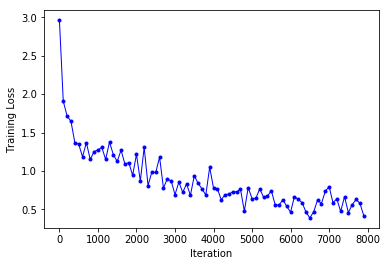

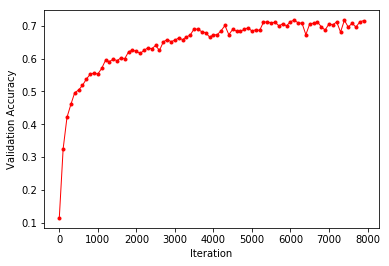

In [19]:
plt.figure()
plt.plot(np.linspace(0, (len(losses)-1)*print_every, len(losses)), np.array(losses), '-bo', lw=1, ms=3)
plt.xlabel('Iteration');
plt.ylabel('Training Loss');

plt.figure()
plt.plot(np.linspace(0, (len(accs)-1)*print_every, len(accs)), np.array(accs), '-ro', lw=1, ms=3)
plt.xlabel('Iteration');
plt.ylabel('Validation Accuracy');
vanilla_accs = accs

## Train OctConv Model on CIFAR

We train a model with the same architecture but using OctConv models instead, with `freq_ratio` = 2.

In [20]:
alphas = [0.125, 0.25, 0.5, 0.75]
freq_ratio = 2
hidden_channels = 32
C, H, W = cifar10_train[0][0].shape
fc_1 = 32
D_out = 10

In [21]:
octconv_model_dict = {}
losses_list = []
accs_list = []
for alpha in alphas:
    octconv_model = get_SixLayerOctConvNet(alpha, freq_ratio, hidden_channels, C, H, W, fc_1, D_out)

    octconv_params = sum(p.numel() for p in octconv_model.parameters() if p.requires_grad)
    print("--------------------------------------------------------------------------")
    print("alpha = " + str(alpha))
    print("Number of parameters in Octconv model: {}".format(octconv_params)) 
    # Octconv doesn't reduce number of parameters, just tensor sizes

    num_epochs = 10
    learning_rate = 5e-4

    optimizer = optim.Adam(octconv_model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

    start = time.time()

    losses, accs = train_cifar(octconv_model, optimizer, epochs=num_epochs)
    losses_list.append(np.array(losses))
    accs_list.append(np.array(accs))

    end = time.time()
    print("Total training time: {} seconds".format(end - start))
    
    octconv_model_dict[str(alpha)] = octconv_model

--------------------------------------------------------------------------
alpha = 0.125
Number of parameters in Octconv model: 103242
Iteration 0, loss = 2.4913
Checking accuracy on validation set
Got 115 / 1000 correct (11.50)

Iteration 100, loss = 1.9664
Checking accuracy on validation set
Got 331 / 1000 correct (33.10)

Iteration 200, loss = 1.6191
Checking accuracy on validation set
Got 368 / 1000 correct (36.80)

Iteration 300, loss = 1.5570
Checking accuracy on validation set
Got 423 / 1000 correct (42.30)

Iteration 400, loss = 1.5320
Checking accuracy on validation set
Got 437 / 1000 correct (43.70)

Iteration 500, loss = 1.4345
Checking accuracy on validation set
Got 471 / 1000 correct (47.10)

Iteration 600, loss = 1.5417
Checking accuracy on validation set
Got 451 / 1000 correct (45.10)

Iteration 700, loss = 1.3953
Checking accuracy on validation set
Got 497 / 1000 correct (49.70)

Iteration 0, loss = 1.2247
Checking accuracy on validation set
Got 498 / 1000 correct (49.8

Got 291 / 1000 correct (29.10)

Iteration 200, loss = 1.5580
Checking accuracy on validation set
Got 392 / 1000 correct (39.20)

Iteration 300, loss = 1.4528
Checking accuracy on validation set
Got 448 / 1000 correct (44.80)

Iteration 400, loss = 1.4512
Checking accuracy on validation set
Got 470 / 1000 correct (47.00)

Iteration 500, loss = 1.4781
Checking accuracy on validation set
Got 482 / 1000 correct (48.20)

Iteration 600, loss = 1.4436
Checking accuracy on validation set
Got 485 / 1000 correct (48.50)

Iteration 700, loss = 1.2275
Checking accuracy on validation set
Got 532 / 1000 correct (53.20)

Iteration 0, loss = 1.2470
Checking accuracy on validation set
Got 533 / 1000 correct (53.30)

Iteration 100, loss = 1.1601
Checking accuracy on validation set
Got 531 / 1000 correct (53.10)

Iteration 200, loss = 1.3189
Checking accuracy on validation set
Got 571 / 1000 correct (57.10)

Iteration 300, loss = 1.0251
Checking accuracy on validation set
Got 573 / 1000 correct (57.30)



Got 452 / 1000 correct (45.20)

Iteration 500, loss = 1.5373
Checking accuracy on validation set
Got 480 / 1000 correct (48.00)

Iteration 600, loss = 1.5849
Checking accuracy on validation set
Got 504 / 1000 correct (50.40)

Iteration 700, loss = 1.2673
Checking accuracy on validation set
Got 519 / 1000 correct (51.90)

Iteration 0, loss = 1.3800
Checking accuracy on validation set
Got 518 / 1000 correct (51.80)

Iteration 100, loss = 1.5486
Checking accuracy on validation set
Got 554 / 1000 correct (55.40)

Iteration 200, loss = 1.2170
Checking accuracy on validation set
Got 543 / 1000 correct (54.30)

Iteration 300, loss = 1.4857
Checking accuracy on validation set
Got 540 / 1000 correct (54.00)

Iteration 400, loss = 0.9995
Checking accuracy on validation set
Got 557 / 1000 correct (55.70)

Iteration 500, loss = 1.6523
Checking accuracy on validation set
Got 562 / 1000 correct (56.20)

Iteration 600, loss = 1.5340
Checking accuracy on validation set
Got 570 / 1000 correct (57.00)



Got 491 / 1000 correct (49.10)

Iteration 0, loss = 1.4501
Checking accuracy on validation set
Got 514 / 1000 correct (51.40)

Iteration 100, loss = 1.2608
Checking accuracy on validation set
Got 532 / 1000 correct (53.20)

Iteration 200, loss = 0.9648
Checking accuracy on validation set
Got 519 / 1000 correct (51.90)

Iteration 300, loss = 1.3383
Checking accuracy on validation set
Got 525 / 1000 correct (52.50)

Iteration 400, loss = 1.3010
Checking accuracy on validation set
Got 536 / 1000 correct (53.60)

Iteration 500, loss = 1.1681
Checking accuracy on validation set
Got 535 / 1000 correct (53.50)

Iteration 600, loss = 1.2362
Checking accuracy on validation set
Got 549 / 1000 correct (54.90)

Iteration 700, loss = 1.1684
Checking accuracy on validation set
Got 569 / 1000 correct (56.90)

Iteration 0, loss = 1.1020
Checking accuracy on validation set
Got 555 / 1000 correct (55.50)

Iteration 100, loss = 1.2206
Checking accuracy on validation set
Got 570 / 1000 correct (57.00)

It

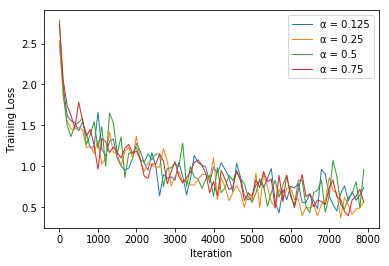

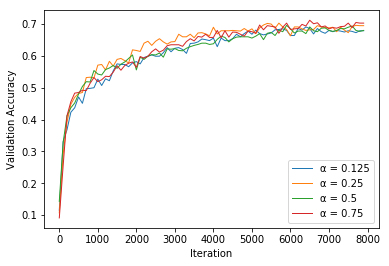

In [22]:
plt.figure()
for ii in range(len(losses_list)):
    plt.plot(np.linspace(0, (losses_list[ii].shape[0]-1)*print_every, losses_list[ii].shape[0]), losses_list[ii], lw=1, ms=3)
plt.xlabel('Iteration');
plt.ylabel('Training Loss');
plt.legend(['α = 0.125', 'α = 0.25', 'α = 0.5', 'α = 0.75'], loc='upper right');

plt.figure()
for ii in range(len(accs_list)):
    plt.plot(np.linspace(0, (accs_list[ii].shape[0]-1)*print_every, accs_list[ii].shape[0]), accs_list[ii], lw=1, ms=3)
plt.xlabel('Iteration');
plt.ylabel('Validation Accuracy');
plt.legend(['α = 0.125', 'α = 0.25', 'α = 0.5', 'α = 0.75'], loc='lower right');

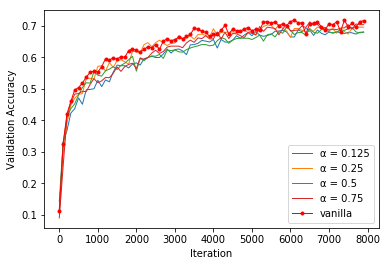

In [23]:
plt.figure()
for ii in range(len(accs_list)):
    plt.plot(np.linspace(0, (accs_list[ii].shape[0]-1)*print_every, accs_list[ii].shape[0]), accs_list[ii], lw=1, ms=3)
plt.plot(np.linspace(0, (len(vanilla_accs)-1)*print_every, len(vanilla_accs)), np.array(vanilla_accs), '-ro', lw=1, ms=3)
plt.xlabel('Iteration');
plt.ylabel('Validation Accuracy');
plt.legend(['α = 0.125', 'α = 0.25', 'α = 0.5', 'α = 0.75', 'vanilla'], loc='lower right');

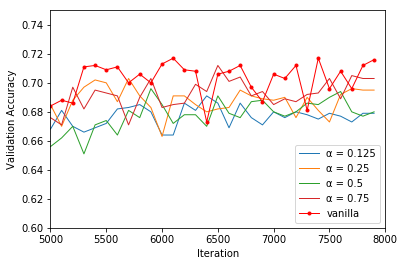

In [24]:
plt.figure()
for ii in range(len(accs_list)):
    plt.plot(np.linspace(0, (accs_list[ii].shape[0]-1)*print_every, accs_list[ii].shape[0]), accs_list[ii], lw=1, ms=3)
plt.plot(np.linspace(0, (len(vanilla_accs)-1)*print_every, len(vanilla_accs)), np.array(vanilla_accs), '-ro', lw=1, ms=3)
plt.xlim(5000, 8000)
plt.ylim(0.6, 0.75)
plt.xlabel('Iteration');
plt.ylabel('Validation Accuracy');
plt.legend(['α = 0.125', 'α = 0.25', 'α = 0.5', 'α = 0.75', 'vanilla'], loc='lower right');

In [25]:
for ii in range(len(accs_list)):
    print('Max training accuracy for α = ' + str(alphas[ii]) + ": " + str(max(accs_list[ii])))
print('Max training accuracy for vanilla CNN: ' + str(max(vanilla_accs)))

Max training accuracy for α = 0.125: 0.691
Max training accuracy for α = 0.25: 0.703
Max training accuracy for α = 0.5: 0.696
Max training accuracy for α = 0.75: 0.712
Max training accuracy for vanilla CNN: 0.717


In [26]:
print("-----------------------------------------")
print("Vanilla CNN: ")
check_accuracy(loader_test, vanilla_model)
for alpha, model in octconv_model_dict.items():
    print("-----------------------------------------")
    print("α = " + str(alpha))
    check_accuracy(loader_test, model)

-----------------------------------------
Vanilla CNN: 
Checking accuracy on test set
Got 6987 / 10000 correct (69.87)
-----------------------------------------
α = 0.125
Checking accuracy on test set
Got 6933 / 10000 correct (69.33)
-----------------------------------------
α = 0.25
Checking accuracy on test set
Got 7029 / 10000 correct (70.29)
-----------------------------------------
α = 0.5
Checking accuracy on test set
Got 6752 / 10000 correct (67.52)
-----------------------------------------
α = 0.75
Checking accuracy on test set
Got 6864 / 10000 correct (68.64)


# Vary spatial frequency ratio

We set $\alpha$ = 0.5 and vary `freq_ratio` to see how the performance of the OctConvNet depends on the spatial frequency.

In [28]:
alpha = 0.5
freq_ratios = [2, 4, 8]
hidden_channels = 32
C, H, W = cifar10_train[0][0].shape
fc_1 = 32
D_out = 10

In [29]:
octconv_model_dict = {}
losses_list = []
accs_list = []
for freq_ratio in freq_ratios:
    octconv_model = get_SixLayerOctConvNet(alpha, freq_ratio, hidden_channels, C, H, W, fc_1, D_out)

    octconv_params = sum(p.numel() for p in octconv_model.parameters() if p.requires_grad)
    print("--------------------------------------------------------------------------")
    print("freq_ratio = " + str(freq_ratio))
    print("Number of parameters in Octconv model: {}".format(octconv_params)) 
    # Octconv doesn't reduce number of parameters, just tensor sizes

    num_epochs = 10
    learning_rate = 5e-4

    optimizer = optim.Adam(octconv_model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

    start = time.time()

    losses, accs = train_cifar(octconv_model, optimizer, epochs=num_epochs)
    losses_list.append(np.array(losses))
    accs_list.append(np.array(accs))

    end = time.time()
    print("Total training time: {} seconds".format(end - start))
    
    octconv_model_dict[str(freq_ratio)] = octconv_model

--------------------------------------------------------------------------
freq_ratio = 2
Number of parameters in Octconv model: 103242
Iteration 0, loss = 2.7703
Checking accuracy on validation set
Got 126 / 1000 correct (12.60)

Iteration 100, loss = 2.0239
Checking accuracy on validation set
Got 251 / 1000 correct (25.10)

Iteration 200, loss = 1.6140
Checking accuracy on validation set
Got 413 / 1000 correct (41.30)

Iteration 300, loss = 1.4255
Checking accuracy on validation set
Got 426 / 1000 correct (42.60)

Iteration 400, loss = 1.6510
Checking accuracy on validation set
Got 455 / 1000 correct (45.50)

Iteration 500, loss = 1.3167
Checking accuracy on validation set
Got 502 / 1000 correct (50.20)

Iteration 600, loss = 1.2675
Checking accuracy on validation set
Got 527 / 1000 correct (52.70)

Iteration 700, loss = 1.1536
Checking accuracy on validation set
Got 525 / 1000 correct (52.50)

Iteration 0, loss = 1.4200
Checking accuracy on validation set
Got 517 / 1000 correct (51.

Got 299 / 1000 correct (29.90)

Iteration 200, loss = 1.7881
Checking accuracy on validation set
Got 373 / 1000 correct (37.30)

Iteration 300, loss = 1.5432
Checking accuracy on validation set
Got 404 / 1000 correct (40.40)

Iteration 400, loss = 1.4794
Checking accuracy on validation set
Got 449 / 1000 correct (44.90)

Iteration 500, loss = 1.4364
Checking accuracy on validation set
Got 459 / 1000 correct (45.90)

Iteration 600, loss = 1.3879
Checking accuracy on validation set
Got 491 / 1000 correct (49.10)

Iteration 700, loss = 1.4669
Checking accuracy on validation set
Got 491 / 1000 correct (49.10)

Iteration 0, loss = 1.3710
Checking accuracy on validation set
Got 503 / 1000 correct (50.30)

Iteration 100, loss = 1.3406
Checking accuracy on validation set
Got 508 / 1000 correct (50.80)

Iteration 200, loss = 1.6140
Checking accuracy on validation set
Got 519 / 1000 correct (51.90)

Iteration 300, loss = 1.1911
Checking accuracy on validation set
Got 511 / 1000 correct (51.10)



Got 427 / 1000 correct (42.70)

Iteration 500, loss = 1.3752
Checking accuracy on validation set
Got 437 / 1000 correct (43.70)

Iteration 600, loss = 1.4151
Checking accuracy on validation set
Got 455 / 1000 correct (45.50)

Iteration 700, loss = 1.8372
Checking accuracy on validation set
Got 472 / 1000 correct (47.20)

Iteration 0, loss = 1.3402
Checking accuracy on validation set
Got 492 / 1000 correct (49.20)

Iteration 100, loss = 1.2695
Checking accuracy on validation set
Got 510 / 1000 correct (51.00)

Iteration 200, loss = 1.4091
Checking accuracy on validation set
Got 505 / 1000 correct (50.50)

Iteration 300, loss = 1.2745
Checking accuracy on validation set
Got 518 / 1000 correct (51.80)

Iteration 400, loss = 1.2794
Checking accuracy on validation set
Got 536 / 1000 correct (53.60)

Iteration 500, loss = 1.0700
Checking accuracy on validation set
Got 556 / 1000 correct (55.60)

Iteration 600, loss = 1.2401
Checking accuracy on validation set
Got 557 / 1000 correct (55.70)



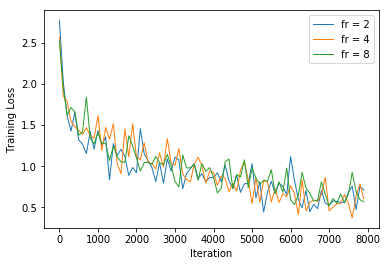

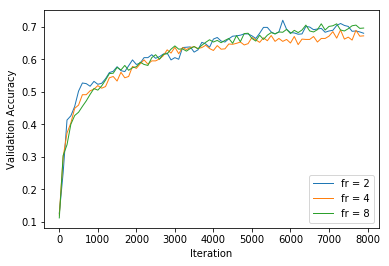

In [30]:
plt.figure()
for ii in range(len(losses_list)):
    plt.plot(np.linspace(0, (losses_list[ii].shape[0]-1)*print_every, losses_list[ii].shape[0]), losses_list[ii], lw=1, ms=3)
plt.xlabel('Iteration');
plt.ylabel('Training Loss');
plt.legend(['fr = 2', 'fr = 4', 'fr = 8'], loc='upper right');

plt.figure()
for ii in range(len(accs_list)):
    plt.plot(np.linspace(0, (accs_list[ii].shape[0]-1)*print_every, accs_list[ii].shape[0]), accs_list[ii], lw=1, ms=3)
plt.xlabel('Iteration');
plt.ylabel('Validation Accuracy');
plt.legend(['fr = 2', 'fr = 4', 'fr = 8'], loc='lower right');

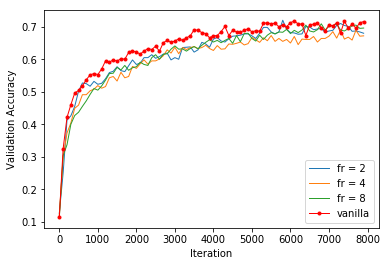

In [31]:
plt.figure()
for ii in range(len(accs_list)):
    plt.plot(np.linspace(0, (accs_list[ii].shape[0]-1)*print_every, accs_list[ii].shape[0]), accs_list[ii], lw=1, ms=3)
plt.plot(np.linspace(0, (len(vanilla_accs)-1)*print_every, len(vanilla_accs)), np.array(vanilla_accs), '-ro', lw=1, ms=3)
plt.xlabel('Iteration');
plt.ylabel('Validation Accuracy');
plt.legend(['fr = 2', 'fr = 4', 'fr = 8', 'vanilla'], loc='lower right');

In [32]:
for ii in range(len(accs_list)):
    print('Max training accuracy for fr = ' + str(freq_ratios[ii]) + ": " + str(max(accs_list[ii])))
print('Max training accuracy for vanilla CNN: ' + str(max(vanilla_accs)))

Max training accuracy for fr = 2: 0.72
Max training accuracy for fr = 4: 0.69
Max training accuracy for fr = 8: 0.709
Max training accuracy for vanilla CNN: 0.717


In [33]:
print("-----------------------------------------")
print("Vanilla CNN: ")
check_accuracy(loader_test, vanilla_model)
for freq_ratio, model in octconv_model_dict.items():
    print("-----------------------------------------")
    print("fr = " + str(freq_ratio))
    check_accuracy(loader_test, model)

-----------------------------------------
Vanilla CNN: 
Checking accuracy on test set
Got 6987 / 10000 correct (69.87)
-----------------------------------------
fr = 2
Checking accuracy on test set
Got 7014 / 10000 correct (70.14)
-----------------------------------------
fr = 4
Checking accuracy on test set
Got 6823 / 10000 correct (68.23)
-----------------------------------------
fr = 8
Checking accuracy on test set
Got 6801 / 10000 correct (68.01)
